In [37]:
try:
    import json
    import os
    
    import pandas as  pd
    import spacy
    
    import seaborn as sns
    import string

    from tqdm import tqdm
    from textblob import TextBlob
    
    from nltk.corpus import stopwords
    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk import word_tokenize
    import re
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    
    from sklearn.preprocessing import FunctionTransformer
    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.pipeline import FeatureUnion
    from sklearn.feature_extraction import DictVectorizer
    
    import swifter
    
    tqdm.pandas()
except Exception as e:
    print("Error : {} ".format(e))

In [38]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/aditya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aditya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/aditya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [39]:
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [40]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


<AxesSubplot:>

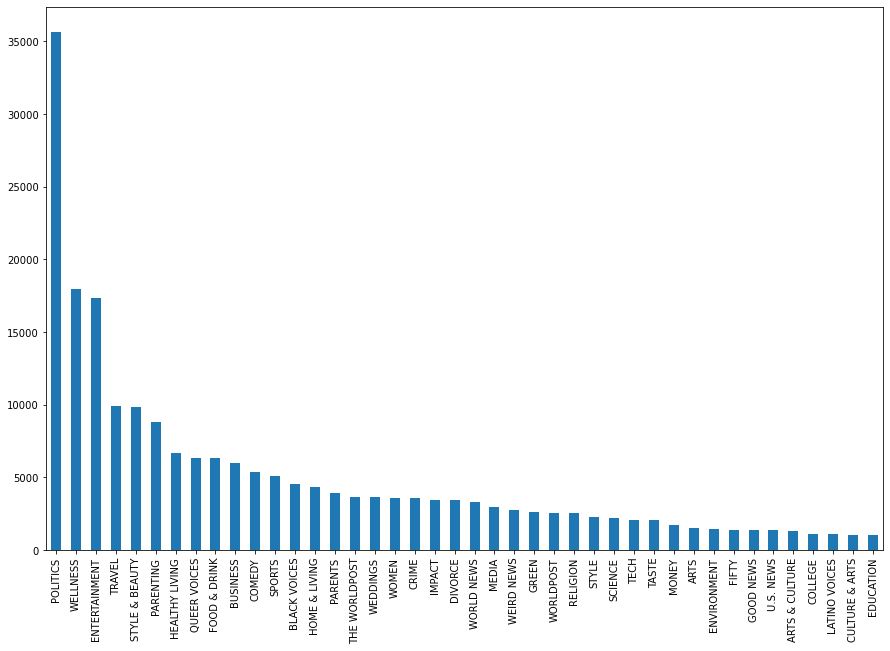

In [41]:
#visualized categories
df['category'].value_counts().plot( kind='bar', figsize=(15,10))

In [42]:
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [43]:
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [79]:
#stop words removal and preprocessing
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()
my_sw = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [90]:
#merged the worldpost and worldpost categories as they are same
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [91]:
# created some news variables columns to try to improve the quaity of our classifier, we will create:
#    Polarity: to check the sentiment of the text
#    Subjectivity: to check if text is objective or subjective
#    The number of word in the text


def subj_txt(text):
    return  TextBlob(text).sentiment[1]

def polarity_txt(text):
    return TextBlob(text).sentiment[0]

def len_text(text):
    if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
    else:
         return 0

In [92]:
df['text'] = df['headline']  +  " " + df['short_description']

df['text'] = df['text'].swifter.apply(clean_txt)
df['polarity'] = df['text'].swifter.apply(polarity_txt)
df['subjectivity'] = df['text'].swifter.apply(subj_txt)
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/209527 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209527 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209527 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209527 [00:00<?, ?it/s]

In [93]:
# label Encoding

X = df[['text', 'polarity', 'subjectivity','len']]
y =df['category']

encoder = LabelEncoder()
y = encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
v = dict(zip(list(y), df['category'].to_list()))

In [94]:
text_clf = Pipeline([
...     ('vect', CountVectorizer(analyzer="word", stop_words="english")),
...     ('tfidf', TfidfTransformer(use_idf=True)),
...     ('clf', MultinomialNB(alpha=.01)),
... ])

In [95]:
text_clf.fit(x_train['text'].to_list(), list(y_train))

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])

In [96]:
import numpy as np
X_TEST = x_test['text'].to_list()
Y_TEST = list(y_test)

In [97]:
predicted = text_clf.predict(X_TEST)

In [98]:
c = 0

for doc, category in zip(X_TEST, predicted):
    
    if c == 2:break
    
    print("-"*55)
    print(doc)
    print(v[category])
    print("-"*55)

    c = c + 1 

-------------------------------------------------------
aroldis chapman become first mlb player ever suspend domestic abuse pitcher appeal decision
SPORTS
-------------------------------------------------------
-------------------------------------------------------
trend talk white converse sneakers
STYLE & BEAUTY
-------------------------------------------------------


In [99]:
np.mean(predicted == Y_TEST)

0.5573187610366057

In [143]:
docs_new = ['cricket world cup ']

In [144]:
predicted = text_clf.predict(docs_new)
v[predicted[0]]

'WEIRD NEWS'